# Bayesian methods for machine learning - Week 2

The purpose of this Notebook is to use Numba for optimizing Numpy-based code. We will use a simple exmaple: implementing the classical K-means algorithm.

### K-means

K-Means is a specific example of expectation maximization algorithm.

Given we have $n$ random $D$-dimensional points $X=\{x_1, x_2, \ldots, x_n\}$, we want to partition these data points into $K$ clusters in the $D$-dimensional space.

Each cluster is represented by its vector representation $\mu_i$ in $\mathcal{R}^{D}$.

To represent belonging of a point $x_n$ to a cluster $k$ we use binary variables $r_{nk}$.

Each data point is assigned to the closests representation of each cluster. The objective function is defined as:

$$
J = \sum^N_{i=1} \sum^K_{k=1} r_{nk} \vert\vert{x_n - \mu_k}\vert\vert^2
$$

To find the values of $\mu_k$ and $r_{nk}$, we will randomly  initialize $mu_k$ and then we will iteratively perform two optimizations:

1. Expectation step: optimize $J$ with respect to $r_{nk}$, keeping $\mu_k$ fixed. As data is independently distributed, optimizing for all points is equivalent to optimizing each point separately. For each point, value of $r_{nk}$ is:

$$
r_{nk} = \begin{cases}
1 & if k = \underset{k}{\mathrm{argmin}} \vert\vert x_n - \mu_k \vert\vert^2 \\
0 & otherwise
\end{cases}
$$

2. Maximization step: optimize $J$ with respect to $\mu_k$ by setting $r_{nk} fixed$. As $J$ is quadratic with respect to $\mu_k$ it is quadratic and has a global minimum, which can be found by finding the roots of the first derivative, for each cluster:

$$
\begin{align*} 
\frac{\partial{J}}{\partial{\mu_k}} & = \sum^N_{i=1} 2 r_{nk} (x_n - \mu_k) \\
                                    & = \sum^N_{i=1} 2 r_{nk} x_n - \sum^N_{i=1} 2 r_{nk} \mu_k \\
\end{align*}
$$

$$
\frac{\partial{J}}{\partial{\mu_k}} \implies \mu_k = \frac{\sum^N_{i=1} r_{nk} x_n}{\sum^N_{i=1} r_{nk}}
$$

Which is the center of mass of the points in each cluster.

Optimizations is performed until no more improvement is found or until maximum number of iterations is reached.

### Python implementation

We will be using Iris dataset to approximate class through K-means. We will be using non-binary $r_{nk}$, instead. But the interpretation of the algorithm is the same.

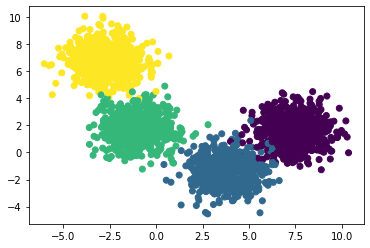

In [1]:
import random
from typing import Tuple

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

from numba import jit

n, n_features, centers = 2500, 6, 4
X, y = datasets.make_blobs(n_samples=n,
                           n_features=n_features,
                           centers=centers,
                           random_state=25)

plt.scatter(X[:, 0], X[:, 1], c=y)

#### Numpy implementation

In [3]:
def _expectation_numpy(X: np.ndarray, mu_k: np.ndarray) -> np.ndarray:
    return np.array([
        np.argmin(np.square(np.linalg.norm(X[i, ...] - mu_k, axis=1)))
        for i in range(len(X))
    ])


def _maximization_numpy(X: np.ndarray, r_nk: np.ndarray, k: int) -> np.ndarray:
    return np.array([
        np.mean(X[r_nk == i, ...], axis=0)
        for i in range(k)
    ])


def _loss_numpy(X: np.ndarray,
                mu_k: np.ndarray,
                r_nk: np.ndarray) -> np.ndarray:
    k = mu_k.shape[0]
    return np.sum([
        np.square(np.linalg.norm(X[r_nk == i, ...] - np.expand_dims(mu_k[i, ...], axis=0)))
        for i in range(k)
    ])


def k_means(X: np.ndarray,
            k: int,
            expectation_fn: callable,
            maximization_fn: callable,
            loss_fn: callable,
            max_iter: int = 50,
            min_delta: float = 1e-3,
            verbose: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Performs K-means on data, returning centers and cluster id for each point
    """

    # Initialize center vectors randomly by selecting instances
    mu_k = np.array(random.choices(X, k=k))
    r_nk = np.random.randint(low=0, high=k, size=(X.shape[0], k))

    iteration = 1
    converged = False
    prev_loss = None
    
    while not converged and iteration < max_iter:

        r_nk = _expectation_numpy(X, mu_k)
        mu_k = _maximization_numpy(X, r_nk, k)
        loss_val = _loss_numpy(X, mu_k, r_nk)

        if verbose:
            print(f'[Iteration: {iteration}] Loss: {loss_val:.2f}')


        if iteration > 1 and prev_loss - loss_val < min_delta:
            if verbose:
                print(f'Improvement was {loss_val:.2f} < {min_delta}. Converged!')
            converged = True

        prev_loss = loss_val
        iteration += 1
    
    return mu_k, r_nk


def k_means_numpy(X, k, **args) -> Tuple[np.ndarray, np.ndarray]:
    return k_means(
        X=X,
        k=k,
        expectation_fn=_expectation_numpy,
        maximization_fn=_maximization_numpy,
        loss_fn=_loss_numpy,
        **args
    )

_, _ = k_means_numpy(X, centers)

#### Numba implementation

[Numba](https://numba.pydata.org/) is a Python package that translates Python code into fast machine code.

Let's see which are the gains we may have by reimplementing the K-means algorithm.

In [4]:
@jit(nopython=True, parallel=True)
def _expectation_numba(X: np.ndarray, mu_k: np.ndarray) -> np.ndarray:
    n, k = X.shape[0], mu_k.shape[0]
    r_nk = np.zeros(n)
    
    for i in range(len(X)):
        distances = np.sum(np.square(X[i] - mu_k), axis=1)
        r_nk[i] = np.argmin(distances)

    return r_nk


@jit(nopython=True, parallel=True)
def _maximization_numba(X: np.ndarray, r_nk: np.ndarray, k: int) -> np.ndarray:
    n_features = X.shape[1]
    mu_k = np.zeros((k, n_features))

    for i in range(k):
        X_k = X[r_nk == i]
        mu_k[i, ...] = np.sum(X_k, axis=0) / len(X_k)

    return mu_k


@jit(nopython=True, parallel=True)
def _loss_numba(X: np.ndarray,
                mu_k: np.ndarray,
                r_nk: np.ndarray) -> np.ndarray:
    k = mu_k.shape[0]
    
    loss = 0
    for i in range(k):
        X_k = X[r_nk == i]
        loss_k = np.sum(np.square(X_k - mu_k[i]))
        loss += loss_k
    
    return loss


def k_means_numba(X: np.ndarray,
                  k: int,
                  **args) -> Tuple[np.ndarray, np.ndarray]:
    return k_means(
        X=X,
        k=k,
        expectation_fn=_expectation_numba,
        maximization_fn=_maximization_numba,
        loss_fn=_loss_numba,
        **args
    )

_, _ = k_means_numba(X, centers)

#### Sanity checks

Make sure the functions implemented, whether using Numba or not, return the same.

In [5]:
k = 3
n, n_features = X.shape
mu_k = np.random.random((k, n_features))
r_nk = np.random.randint(low=0, high=k+1, size=n)

assert np.array_equal(_expectation_numpy(X, mu_k), _expectation_numba(X, mu_k))
assert np.array_equal(_maximization_numpy(X, r_nk, k), _maximization_numba(X, r_nk, k))
assert np.isclose(_loss_numpy(X, mu_k, r_nk), _loss_numba(X, mu_k, r_nk), rtol=0.001)

#### Compare performances

In [7]:
%timeit k_means_numpy(X, centers)

431 ms ± 79.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit k_means_numba(X, centers)

The slowest run took 15.15 times longer than the fastest. This could mean that an intermediate result is being cached.
362 ms ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Plot results.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[Iteration: 1] Loss: 43978.86
[Iteration: 2] Loss: 15475.30
[Iteration: 3] Loss: 15179.05
[Iteration: 4] Loss: 15179.05
Improvement was 15179.05 < 0.001. Converged!


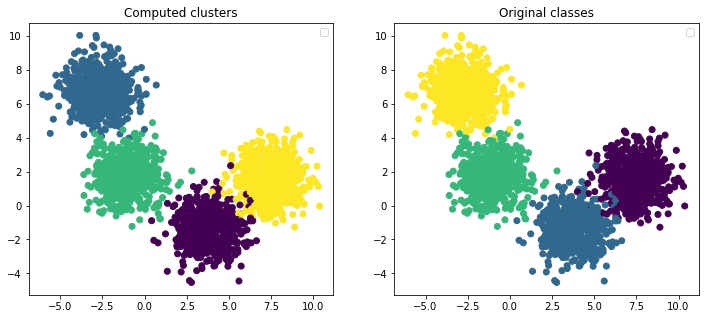

In [18]:
mu_k, r_nk = k_means_numba(X, k=centers, verbose=True)

_, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X[:, 0], X[:, 1], c=r_nk)
axs[0].set_title('Computed clusters')
axs[1].scatter(X[:, 0], X[:, 1], c=y)
axs[1].set_title('Original classes')
axs[0].legend()
axs[1].legend()

#### Disclaimer

Note that Sklearn as already a really fast implementation of the algorithm that should be used instead.

In [10]:
from sklearn.cluster import KMeans
%timeit KMeans(n_clusters=centers).fit(X)

47.8 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
